Para utilizarmos nossos próprios dados, utilizamos o módulo Dataset para criar toda a estrutura necessária.

Dados: https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset

Com esses dados, podemos prever a **quantidade de aluguéis**, sendo assim um problema de regressão.

Features:
- instant: record index;
- dteday : date;
- season : season (1:winter, 2:spring, 3:summer, 4:fall);
- yr : year (0: 2011, 1:2012);
- mnth : month ( 1 to 12);
- hr : hour (0 to 23);
- holiday : weather day is holiday or not;
- weekday : day of the week;
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.;
+ weathersit :
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale);
- atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale);
- hum: Normalized humidity. The values are divided to 100 (max);
- windspeed: Normalized wind speed. The values are divided to 67 (max);
- casual: count of casual users;
- registered: count of registered users;
- cnt: count of total rental bikes including both casual and registered;

In [20]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [21]:
# Download dos dados direto do site
! wget https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip
! unzip Bike-Sharing-Dataset.zip
! ls

--2021-09-17 16:51:42--  https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 279992 (273K) [application/x-httpd-php]
Saving to: ‘Bike-Sharing-Dataset.zip.1’

Bike-Sharing-Datase 100%[===================>] 273.43K   423KB/s    in 0.6s    

2021-09-17 16:51:44 (423 KB/s) - ‘Bike-Sharing-Dataset.zip.1’ saved [279992/279992]

Archive:  Bike-Sharing-Dataset.zip
replace Readme.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Readme.txt              
replace day.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: day.csv                 
replace hour.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: hour.csv                
Bike-Sharing-Dataset.zip    bike_teste.csv   day.csv   Readme.txt
Bike-Sharing-Dataset.zip.1  bike_t

In [22]:
df = pd.read_csv('hour.csv')
print('Formato dos dados:', df.shape)
df.head()

Formato dos dados: (17379, 17)


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


# Divisão dos dados em Treino / Teste

In [23]:
torch.manual_seed(1)
indices = torch.randperm(len(df)).tolist() # sort da quantidade len(df) de indices aleatorios

tam_treino = int(0.8 * len(df)) # 80% de treino
df_treino = df.iloc[indices[:tam_treino]] # Primeiros 80% indices aleatorios do df
df_teste = df.iloc[indices[tam_treino:]] # Ultimos 20% indices aleatorios do df

print('Tamanho treino:', len(df_treino))
print('Tamanho teste:', len(df_teste))

# Salando o csv dos dfs
df_treino.to_csv('bike_treino.csv', index=False)
df_teste.to_csv('bike_teste.csv', index=False)

print('\nArquivos:')
! ls

Tamanho treino: 13903
Tamanho teste: 3476

Arquivos:
Bike-Sharing-Dataset.zip    bike_teste.csv   day.csv   Readme.txt
Bike-Sharing-Dataset.zip.1  bike_treino.csv  hour.csv  sample_data


# Construindo o Dataset

In [24]:
class Bicicretinha(Dataset):
    def __init__(self, csv_caminho):
        self.dados = pd.read_csv(csv_caminho).to_numpy()

    def __getitem__(self, idx):
        sample = self.dados[idx][2:14] # Colunas de features [2:14]
        label = self.dados[idx][-1:] # Coluna de valor

        # Conversao para tensor
        sample = torch.from_numpy(sample.astype(np.float32))
        label = torch.from_numpy(label.astype(np.float32))

        return sample, label # retorna uma tupla contendo as features e label de um dado

    def __len__(self):
        return len(self.dados)

In [27]:
dados_treino = Bicicretinha('bike_treino.csv')
dados_teste = Bicicretinha('bike_teste.csv')

# Extraindo um dado de treino da posição 0:
dado, rotulo = dados_treino[0]
print('Features:', dado)
print('Label:', rotulo)

Features: tensor([ 4.0000,  1.0000, 11.0000, 19.0000,  0.0000,  4.0000,  1.0000,  1.0000,
         0.3800,  0.3939,  0.2700,  0.3582])
Label: tensor([373.])


# Construindo o Dataloader

In [37]:
args = {
    'batch_size' : 20,
    'qtd_processos' : 2,
    'lr' : 1e-4,
    'weight_decay' : 5e-4,
    'qtd_epocas' : 30
}

if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')

treino_loader = DataLoader(dados_treino,
                           batch_size=args['batch_size'],
                           shuffle=True,
                           num_workers=args['qtd_processos'])

teste_loader = DataLoader(dados_teste,
                           batch_size=args['batch_size'],
                           shuffle=True,
                           num_workers=args['qtd_processos'])

In [33]:
for batch in treino_loader:
    dado, rotulo = batch

    print('Batch Dado shape:', dado.size()) # 20 amostras de 12 dimensoes
    print('Batch Rotulo shape:', rotulo.size()) # 20 amostras de 1 dimensao

    break

Batch Dado shape: torch.Size([20, 12])
Batch Rotulo shape: torch.Size([20, 1])


# Construindo o Multi Layer Perceptron

In [65]:
class RedinhaNeurinha(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RedinhaNeurinha, self).__init__()

        # duas camadas hidden
        self.hidden = nn.Sequential(
                            nn.Linear(input_size, hidden_size),
                            nn.ReLU(),
                            nn.Linear(hidden_size, hidden_size),
                            nn.ReLU()
                        )
        # uma camada de saída
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, X):
        feature = self.hidden(X)
        output = self.output(feature)

        return output

In [66]:
input_size = len(dados_treino[0][0]) # qtd de features, no nosso caso é 12
hidden_size = 128 # qtd de neuronios na hidden
output_size = 1 # qtd de variaveis que serão preditas, nesse caso é 1, que é a quatidade de aluguéis

In [67]:
net = RedinhaNeurinha(input_size, hidden_size, output_size).to(args['device'])

## Definindo a Loss e o Otimizador

In [68]:
criterion = nn.L1Loss().to(args['device']) # Loss L1 que é para regressão
optimizer = optim.Adam(net.parameters(), lr = args['lr'], weight_decay = args['weight_decay']) # Otimizador Adam

## Fluxo de treino e validação

In [69]:
def treino(net, treino_loader, epoca):
    net.train() # garante que a rede está em modo de treino
    
    epoca_loss = []
    
    # Iterar nos batches;
    for batch in treino_loader:
        dado, label = batch

        # Cast dos dados no dispositivo de hardware;
        dado = dado.to(args['device'])
        label = label.to(args['device'])

        # Forward na rede e cálculo da loss;
        pred = net(dado)
        loss = criterion(pred, label)

        epoca_loss.append(loss.cpu().data)

        # Cálculo do gradiente e atualização dos pesos (backpropagation)
        loss.backward()
        optimizer.step()

    epoca_loss = np.asarray(epoca_loss)
    print("Treino, Loss: %.4f +/- %.4f" % (epoca_loss.mean(), epoca_loss.std()))
    return epoca_loss.mean()

def teste(net, teste_loader, epoca):
    net.eval() # garante que a rede está no modo de teste
    
    with torch.no_grad():
    
        epoca_loss = []
        
        # Iterar nos batches;
        for batch in teste_loader:
            dado, label = batch

            # Cast dos dados no dispositivo de hardware;
            dado = dado.to(args['device'])
            label = label.to(args['device'])

            # Forward na rede e cálculo da loss;
            pred = net(dado)
            loss = criterion(pred, label)

            # Não tem o backpropagation durante o teste, 
            # dessa forma não leva em consideração os dados de teste para o treino

            epoca_loss.append(loss.cpu().data)

        epoca_loss = np.asarray(epoca_loss)
        print("Teste, Loss: %.4f +/- %.4f" % (epoca_loss.mean(), epoca_loss.std()))
        return epoca_loss.mean()

In [70]:
treino_losses = []
teste_losses = []

for epoca in range(args['qtd_epocas']):
    print('\nEpoca', epoca+1, '-----------------------')
    treino_losses.append(treino(net, treino_loader, epoca))
    teste_losses.append(teste(net, teste_loader, epoca))


Epoca 1 -----------------------
Treino, Loss: 151.5552 +/- 41.0068
Teste, Loss: 131.5143 +/- 21.1674

Epoca 2 -----------------------
Treino, Loss: 123.9382 +/- 32.2745
Teste, Loss: 115.1062 +/- 23.2692

Epoca 3 -----------------------
Treino, Loss: 120.7297 +/- 27.6338
Teste, Loss: 121.0091 +/- 31.3144

Epoca 4 -----------------------
Treino, Loss: 117.5684 +/- 28.4133
Teste, Loss: 114.2642 +/- 28.3867

Epoca 5 -----------------------
Treino, Loss: 115.3002 +/- 27.0029
Teste, Loss: 111.3541 +/- 26.4279

Epoca 6 -----------------------
Treino, Loss: 108.9212 +/- 28.1885
Teste, Loss: 109.4161 +/- 23.0345

Epoca 7 -----------------------
Treino, Loss: 102.8053 +/- 27.5062
Teste, Loss: 103.4024 +/- 24.8582

Epoca 8 -----------------------
Treino, Loss: 99.2586 +/- 23.9816
Teste, Loss: 98.2588 +/- 20.7309

Epoca 9 -----------------------
Treino, Loss: 97.4843 +/- 24.2378
Teste, Loss: 90.3849 +/- 23.2288

Epoca 10 -----------------------
Treino, Loss: 96.0841 +/- 24.7849
Teste, Loss: 91.17

## Gráfico de convergência

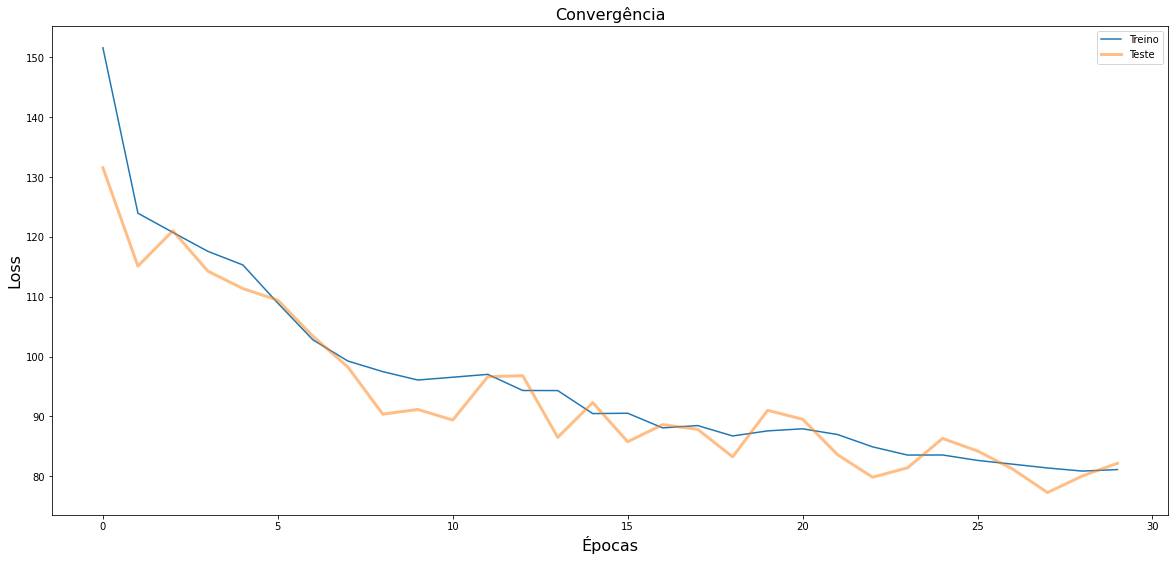

In [71]:
plt.figure(figsize=(20,9))
plt.plot(treino_losses, label='Treino')
plt.plot(teste_losses, label='Teste', linewidth=3, alpha=0.5)
plt.xlabel("Épocas", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.title("Convergência", fontsize=16)
plt.legend()
plt.show()